Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

=== Averaged Results Over 10 Runs ===
Accuracy:  0.8483
Precision: 0.7574
Recall:    0.7083
F1-score:  0.7266
ROC-AUC:   0.8715


<ipython-input-6-9dbab37abcd4>:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=resultsDF, palette='coolwarm')


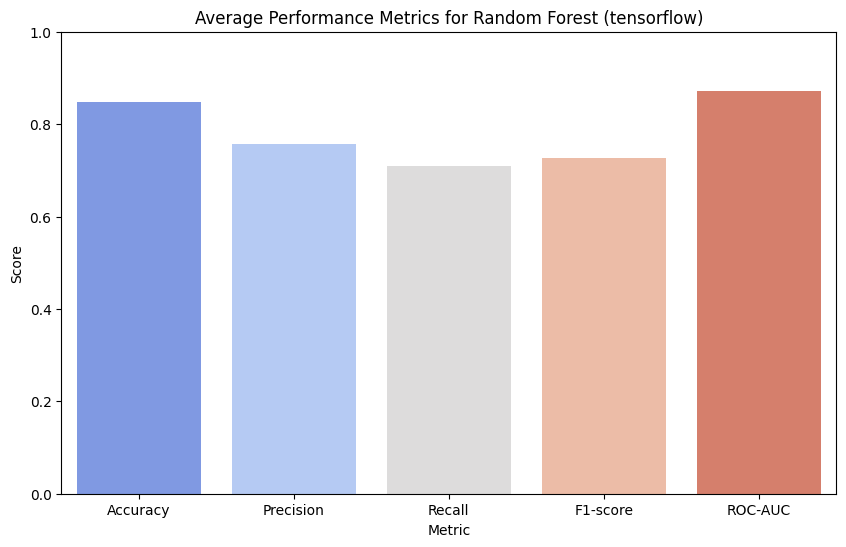

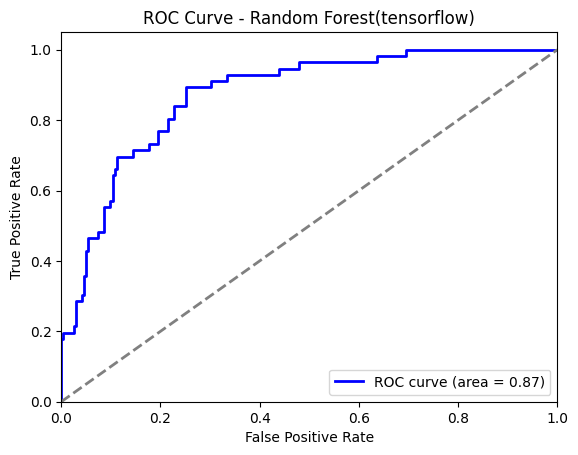


 Full run-by-run results saved to: /content/drive/MyDrive/tensorflowRF.csv


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

########## Import required libraries ##########

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for feature extraction, evaluation, and modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier

# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

# NLTK for stopwords and text cleaning
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## Defining text preprocessing functions ##########

def removeHtml(text):
    """Remove HTML tags from the text."""
    return re.sub(r'<.*?>', '', text)

def removeEmoji(text):
    """Remove emojis using a regex pattern."""
    emojiPattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emojiPattern.sub(r'', text)

# Stopwords set
stopWords = set(stopwords.words('english'))

def preprocessText(text):
    """Clean and normalise the input text."""
    text = removeHtml(text)
    text = removeEmoji(text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return ' '.join(word.lower() for word in text.split() if word.lower() not in stopWords)


########## Load dataset and prepare the text ##########

# Define the project and load the CSV from Google Drive
project = 'tensorflow' # Change this to run model on different datasets
filePath = f'/content/drive/MyDrive/{project}.csv'
dataRaw = pd.read_csv(filePath).sample(frac=1, random_state=42)

# Merge Title and Body into a unified text column
dataRaw['Title+Body'] = dataRaw.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Rename to match baseline Naive Bayes format and save
dataBaselineFormat = dataRaw.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
dataBaselineFormat.to_csv('Title+Body_RF.csv', index=False, columns=["id", "Number", "sentiment", "text"])

##########  Preprocess the text and prepare for the model ##########

# Make a working copy and clean the text
data = dataBaselineFormat.copy()
data['text'] = data['text'].fillna('').apply(preprocessText)

# Vectorise the text using TF-IDF with n grams
tfidfAll = TfidfVectorizer(max_features=2500, ngram_range=(1, 3))
XtfidfAll = tfidfAll.fit_transform(data['text'])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
Xresampled, yResampled = smote.fit_resample(XtfidfAll, data['sentiment'])


##########  Hyperparameter tuning using GridSearchCV ##########

# Define the grid of parameters to search
paramGrid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# Train using grid search
gridSearch = GridSearchCV(
    RandomForestClassifier(random_state=42),
    paramGrid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)
gridSearch.fit(Xresampled, yResampled)
bestParams = gridSearch.best_params_
print("Best Hyperparameters:", bestParams)


########## Train and evaluate Random Forest across 10 runs ##########

repeatCount = 10
accuracyList, precisionList, recallList, f1ScoreList, aucList = [], [], [], [], []

for i in range(repeatCount):
    Xtrain, Xtest, yTrain, yTest = train_test_split(
        data['text'], data['sentiment'], test_size=0.2, random_state=i, stratify=data['sentiment'])

    tfidf = TfidfVectorizer(max_features=2500, ngram_range=(1, 3))
    XtrainTfidf = tfidf.fit_transform(Xtrain)
    XtestTfidf = tfidf.transform(Xtest)

    smote = SMOTE(random_state=42)
    XtrainSmote, yTrainSmote = smote.fit_resample(XtrainTfidf, yTrain)

    model = RandomForestClassifier(**bestParams, random_state=42)
    model.fit(XtrainSmote, yTrainSmote)

    yPred = model.predict(XtestTfidf)
    yPredProb = model.predict_proba(XtestTfidf)[:, 1]

    accuracyList.append(accuracy_score(yTest, yPred))
    precisionList.append(precision_score(yTest, yPred, average='macro', zero_division=0))
    recallList.append(recall_score(yTest, yPred, average='macro', zero_division=0))
    f1ScoreList.append(f1_score(yTest, yPred, average='macro', zero_division=0))
    aucList.append(roc_auc_score(yTest, yPredProb))


########## Calculate and print the average of the metrics ##########

avgAccuracy = np.mean(accuracyList)
avgPrecision = np.mean(precisionList)
avgRecall = np.mean(recallList)
avgF1Score = np.mean(f1ScoreList)
avgAUC = np.mean(aucList)

print("\n=== Averaged Results Over 10 Runs ===")
print(f"Accuracy:  {avgAccuracy:.4f}")
print(f"Precision: {avgPrecision:.4f}")
print(f"Recall:    {avgRecall:.4f}")
print(f"F1-score:  {avgF1Score:.4f}")
print(f"ROC-AUC:   {avgAUC:.4f}")


########## Plot bar chart for average metrics ##########

resultsDF = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Score': [avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgAUC]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=resultsDF, palette='coolwarm')
plt.title(f'Average Performance Metrics for Random Forest ({project})')
plt.ylim(0, 1)
plt.show()


########## Plot ROC curve from the last test run ##########

fpr, tpr, _ = roc_curve(yTest, yPredProb)
rocAUCValue = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {rocAUCValue:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Random Forest({project})')
plt.legend(loc="lower right")
plt.show()



########## Save raw results for each run and mean to CSV ##########

# Create a DataFrame with raw metrics from each run
dfraw = pd.DataFrame({
    'run': list(range(1, repeatCount + 1)),
    'Accuracy': accuracyList,
    'Precision': precisionList,
    'Recall': recallList,
    'F1': f1ScoreList,
    'AUC': aucList
})

# Append average as final row
dfavg = pd.DataFrame({
    'run': ['Average'],
    'Accuracy': [avgAccuracy],
    'Precision': [avgPrecision],
    'Recall': [avgRecall],
    'F1': [avgF1Score],
    'AUC': [avgAUC]
})

df_full_results = pd.concat([dfraw, dfavg], ignore_index=True)

# Save to Google Drive
full_results_path = f'/content/drive/MyDrive/{project}RF.csv'
df_full_results.to_csv(full_results_path, index=False)
print(f"\n Full run-by-run results saved to: {full_results_path}")




Class distribution before SMOTE:
sentiment
0    1211
1     279
Name: count, dtype: int64
sentiment
0    0.812752
1    0.187248
Name: proportion, dtype: float64


<ipython-input-59-022c43d5df2f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='coolwarm')


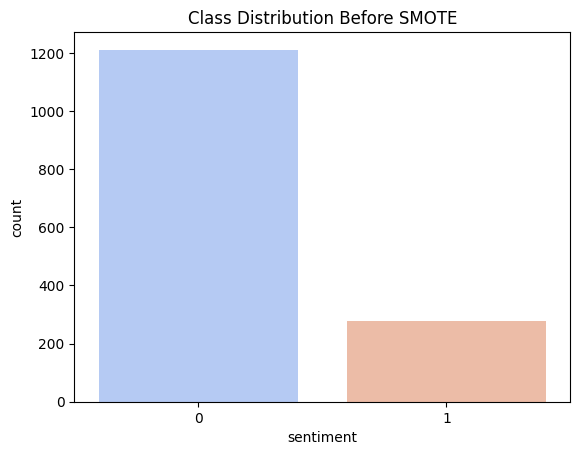

In [ ]:
##########  Visualise class imbalance before and after SMOTE ##########

# Class distribution before SMOTE
print("Class distribution before SMOTE:")
print(data['sentiment'].value_counts())
print(data['sentiment'].value_counts(normalize=True))

sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title('Class Distribution Before SMOTE')
plt.show()

Class distribution after SMOTE oversampling:
sentiment
0    969
1    969
Name: count, dtype: int64


<ipython-input-60-22bd38038163>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=yTrainSmote, palette='coolwarm')


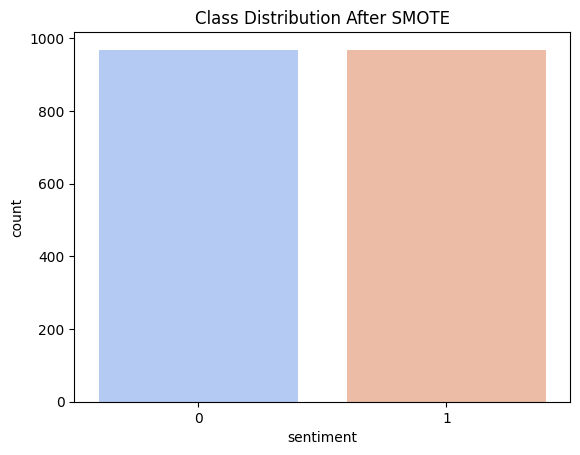

In [ ]:
## Class distribution after SMOTE
print("Class distribution after SMOTE oversampling:")
print(pd.Series(yTrainSmote).value_counts())

sns.countplot(x=yTrainSmote, palette='coolwarm')
plt.title('Class Distribution After SMOTE')
plt.show()

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define text preprocessing methods
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

# Read data from your Google Drive
project = 'tensorflow'
file_path = '/content/drive/MyDrive/tensorflow.csv'
pd_all = pd.read_csv(file_path).sample(frac=1, random_state=999)

# Merge Title and Body into one column
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Prepare final DataFrame and save
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])

# Configure parameters
datafile = 'Title+Body.csv'
REPEAT = 10
out_csv_name = f'../{project}_NB.csv'

# Read and clean data
data = pd.read_csv(datafile).fillna('')
text_col = 'text'
data[text_col] = data[text_col].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)

# Hyperparameter grid
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Metrics storage
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

for repeated_time in range(REPEAT):
    # Split data
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(indices, test_size=0.2, random_state=repeated_time)
    train_text, test_text = data[text_col].iloc[train_index], data[text_col].iloc[test_index]
    y_train, y_test = data['sentiment'].iloc[train_index], data['sentiment'].iloc[test_index]

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train, X_test = tfidf.fit_transform(train_text).toarray(), tfidf.transform(test_text).toarray()

    # Train Naive Bayes with GridSearch
    clf = GaussianNB()
    grid = GridSearchCV(clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = best_clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_values.append(auc(fpr, tpr))

# Aggregate results
final_accuracy = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall = np.mean(recalls)
final_f1 = np.mean(f1_scores)
final_auc = np.mean(auc_values)

# Print results
print("=== Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")

# Save results to CSV
try:
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame({
    'repeated_times': [REPEAT],
    'Accuracy': [final_accuracy],
    'Precision': [final_precision],
    'Recall': [final_recall],
    'F1': [final_f1],
    'AUC': [final_auc],
    'CV_list(AUC)': [str(auc_values)]
})

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)
print(f"\nResults have been saved to: {out_csv_name}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.5617
Average Precision:     0.6360
Average Recall:        0.7227
Average F1 score:      0.5397
Average AUC:           0.7227

Results have been saved to: ../tensorflow_NB.csv


In [ ]:
##########  Paired t-test between Random Forest and Naive Bayes ##########

from scipy.stats import ttest_rel

# Perform t-test using F1 scores from both models
tStatistic, pValue = ttest_rel(f1ScoreList, f1_scores)

print("Paired t-test (F1-score)")
print(f"T-statistic: {tStatistic:.4f}")
print(f"P-value: {pValue:.4f}")

if pValue < 0.05:
    print("Statistically significant difference (p < 0.05)")
else:
    print("No statistically significant difference (p ≥ 0.05)")


Paired t-test (F1-score)
T-statistic: 19.6114
P-value: 0.0000
Statistically significant difference (p < 0.05)


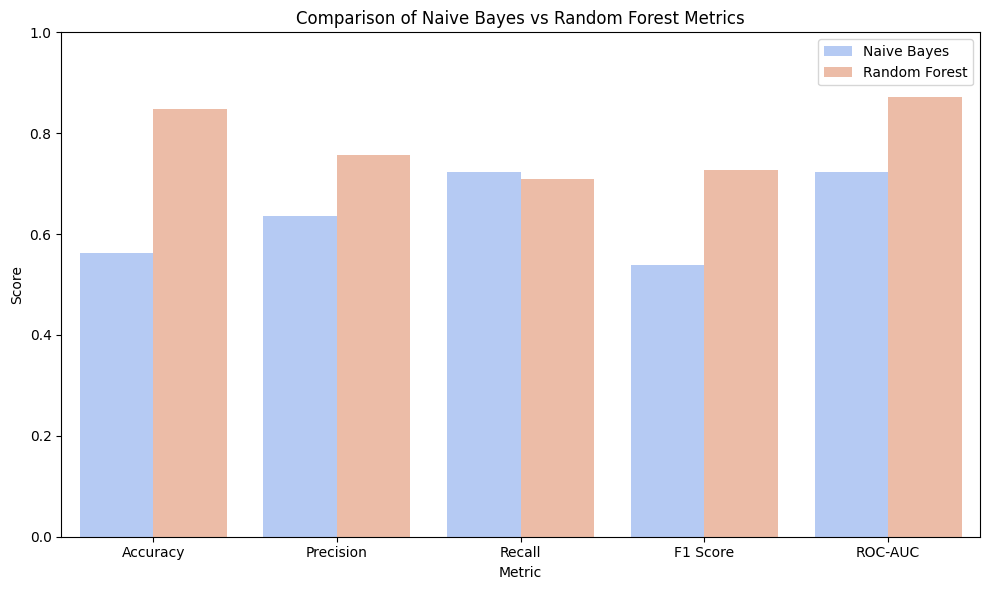

In [2]:
########## Visual comparison between Naive Bayes and Random Forest ##########

# Naive Bayes static values
nbAccuracy = 0.5617
nbPrecision = 0.6360
nbRecall = 0.7227
nbF1 = 0.5397
nbRocAUC = 0.7227

# Creating a comparison DataFrame
comparisonDF = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Naive Bayes": [nbAccuracy, nbPrecision, nbRecall, nbF1, nbRocAUC],
    "Random Forest": [avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgAUC]
})

# seaborn plotting
meltedDF = comparisonDF.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=meltedDF, palette="coolwarm")
plt.title("Comparison of Naive Bayes vs Random Forest Metrics")
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

